In [2]:
from sklearn import datasets
import pandas as pd
import numpy as np
from typing import List, Union
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, f1_score

# Load the dataset and conduct its initial check

In [4]:
df = pd.read_csv('content/winequality-red.csv', sep=";")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [6]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [7]:
for col in df.columns:
    unique_count = df[col].nunique()  # Get a number of unique value for each column
    uniq_data = df[col].unique()  # We get an array of unique values for each column
    
    # We check whether all values can be converted into numbers 
    is_numeric = pd.to_numeric(df[col], errors='coerce').notnull().all()
    
    if is_numeric:
        print(f"Столбец '{col}': уникальных значений {unique_count} - цифровые значения")
    else:
        print(f"Столбец '{col}': уникальных значений {unique_count} - {list(uniq_data[:5])}")

Столбец 'fixed acidity': уникальных значений 96 - цифровые значения
Столбец 'volatile acidity': уникальных значений 143 - цифровые значения
Столбец 'citric acid': уникальных значений 80 - цифровые значения
Столбец 'residual sugar': уникальных значений 91 - цифровые значения
Столбец 'chlorides': уникальных значений 153 - цифровые значения
Столбец 'free sulfur dioxide': уникальных значений 60 - цифровые значения
Столбец 'total sulfur dioxide': уникальных значений 144 - цифровые значения
Столбец 'density': уникальных значений 436 - цифровые значения
Столбец 'pH': уникальных значений 89 - цифровые значения
Столбец 'sulphates': уникальных значений 96 - цифровые значения
Столбец 'alcohol': уникальных значений 65 - цифровые значения
Столбец 'quality': уникальных значений 6 - цифровые значения


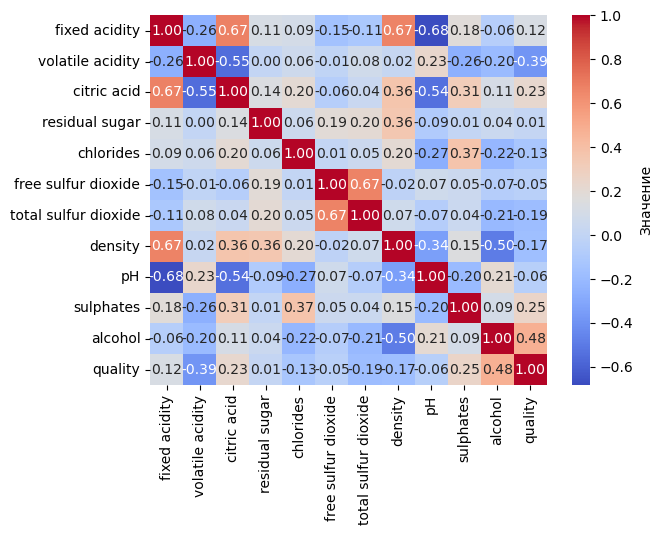

In [8]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f', cbar_kws={'label': 'Значение'})
plt.show()

# We make a division of the Dataset and prepare the model for training

In [9]:
X = df.drop(columns=["quality"])  
y = df["quality"] 

# Divided by 80% of training and 20% test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Create a class for SVR as an error function- Huber Loss

In [12]:
class SVRCustom:
    """
    Class for calculating and learning models of support vectors with regression (SVR).
    
    This class implements the Support Vector Regression (SVR) learning method using gradient descent.
    Includes support for various types of nuclei, calculating the functions of Huber Loss losses and an adaptive step in learning.
    
    Attributes:
    Kernel (str): type of nucleus. Supported values: 'Linear', 'RBF', 'Poly'.
    C (Float): Regularization parameter. The higher, the less the error, but the more chance of retraining.
    Epsilon (Float): a parameter for determining the error when calculating losses.
    Gamma (Str or Float): RBF nucleus parameter. Can be 'scale' or number.
    Degree (int): degree of polynomial nucleus.
    ETA0 (Float): An initial step for a gradient descent.
    Lambda_Decay (Float): coefficient of attenuation of a step of learning as iterations.
    Max_iter (int): the maximum number of iterations for learning.
    Delta (Float): a parameter for Huber Loss, which controls when the error is quantized.
    
    Methods:
    Huber_loss (y_true, y_pred): Calculation of Huber Loss for data.
    Huber_gradient (y_true, y_pred): calculating the Huber Loss gradient for data.
    Compute_Kernel (x): calculating the nucleus matrix depending on the selected type of nucleus.
    Fit (x, y): training in a model using gradient descent.
    Predict (x): obtaining a prediction based on a trained model.
    PLOT_LOSS (MAX = 0): Building the Guber Loss error graph during training.
    """
    
    def __init__(self, kernel='linear', C=1.0, epsilon=0.1, gamma='scale', degree=3, eta0=0.1, lambda_decay=0.01, max_iter=1000, delta=1.0):
        """
         Initialization of the SVR model.
        
         Parameters:
         SELF.KERNEL (str): type of nucleus. Supported 'Linear', 'RBF', 'Poly'.
         SELF.C (FLOAT): the regulatory parameter (default 1.0).
         Self.epsilon (Float): a parameter that determines the width of tolerances (default 0.1).
         Self.gamma (Str or Float): RBF nucleus parameter (default 'scale').
         Self.degree (int): degree of polynomial nucleus (by default 3).
         Self.eta0 (Float): An initial step for a gradient descent (default 0.1).
         Self.lambda_Decay (Float): The attenuation coefficient for the step (by default 0.01).
         SELF.MAX_ITER (int): the maximum number of iterations (default 1000).
         Self.Delta (Float): Parameter for Huber Loss (default 1.0).
         """
        self.kernel: str = kernel
        self.C: float = C
        self.epsilon: float = epsilon
        self.gamma: str|float = gamma
        self.degree: int = degree
        self.eta0: float = eta0  # Начальный шаг
        self.lambda_decay: float = lambda_decay  # Коэффициент затухания шага
        self.max_iter: int = max_iter
        self.delta: float = delta  # Параметр для Huber Loss
        self.w: float = None
        self.b: float = 0
        self.loss_history: List  = []

    def huber_loss(self, y_true: np.ndarray, y_pred: np.ndarray)->float:
        """
         Calculation of Huber Loss for data.
        
         Huber Loss is a combination of MSE and MAE, where a quadratic error is used for small deviations,
         And for large deviations - linear.
        
         Parameters:
         y_true (Array-Like): True meanings.
         Y_PRED (Array-Like): predicted values.
        
         Returns:
         Float: The average value of Huber Loss.
         """
        diff: float = y_pred - y_true
        abs_diff = np.abs(diff)
        
        # Вычисление Huber Loss
        loss = np.where(abs_diff <= self.delta, 0.5 * diff ** 2, self.delta * (abs_diff - 0.5 * self.delta))
        return np.mean(loss)

    def huber_gradient(self, y_true: np.ndarray, y_pred: np.ndarray)->float:
        """
         Calculation of the Huber Loss gradient for data.
        
         The gradient is used to update the model weights using gradient descent.
        
         Parameters:
         y_true (Array-Like): True meanings.
         Y_PRED (Array-Like): predicted values.
        
         Returns:
         Array: Losses gradient in relation to each attribute.
         """
        diff = y_pred - y_true
        abs_diff = np.abs(diff)
        
        # Градиент для Huber Loss
        grad = np.where(abs_diff <= self.delta, diff, self.delta * np.sign(diff))
        return grad

    def compute_kernel(self, X: np.ndarray):
        """
         Calculation of the nucleus matrix depending on the type of nucleus.
        
         Supported types of nuclei: linear, RBF, polynomial.
        
         Parameters:
         X (Array-Like): input data (signs matrix).
        
         Returns:
         Array: The matrix of the nucleus.
         """
        if self.kernel == 'linear':
            return X
        elif self.kernel == 'rbf':
            if self.gamma == 'scale':
                self.gamma = 1 / (X.shape[1] * np.var(X))
            K = np.exp(-self.gamma * np.linalg.norm(X[:, np.newaxis] - X, axis=2) ** 2)
            return K
        elif self.kernel == 'poly':
            return (X @ X.T + 1) ** self.degree
        else:
            raise ValueError("Unsupported kernel")

    def fit(self, X: np.ndarray, y: np.ndarray):
        """
         Model training using gradient descent.
        
         Parameters:
         X (Array-Like): input data (signs matrix).
         Y (Array-Like): target values.
         """
        X = np.array(X)
        y = np.array(y)
        self.w: float = np.random.randn(X.shape[1])  # Инициализация весов
        self.b: float = np.random.randn()
        
        for t in range(1, self.max_iter + 1):
            eta_t = self.eta0 / (1 + self.lambda_decay * t)  # Адаптивный шаг
            y_pred = X @ self.w + self.b
            
            grad_w: float = np.mean(self.huber_gradient(y, y_pred)[:, np.newaxis] * X, axis=0)
            grad_b: float = np.mean(self.huber_gradient(y, y_pred))
            
            self.w -= eta_t * grad_w
            self.b -= eta_t * grad_b
            
            loss = self.huber_loss(y, y_pred)
            self.loss_history.append(loss)
        
    def predict(self, X: np.ndarray)-> np.ndarray:
        """
         Obtaining a prediction based on a trained model.
        
         Parameters:
         X (Array-Like): Entrance data for prediction.
        
         Returns:
         Array: predicted values.
         """
        return X @ self.w + self.b

    def plot_loss(self, max: int=0):
        """
         Building a graph of error changes (Huber Loss) during training.
        
         Parameters:
         Max (Float): Limit on the Y axis for the graph (by default 0).
         """
        plt.plot(range(1, self.max_iter + 1), self.loss_history)
        plt.xlabel('Итерация')
        plt.ylabel('Huber Loss')
        if max != 0:
            plt.ylim(0, max)
        plt.title('График изменения ошибки')
        plt.show()



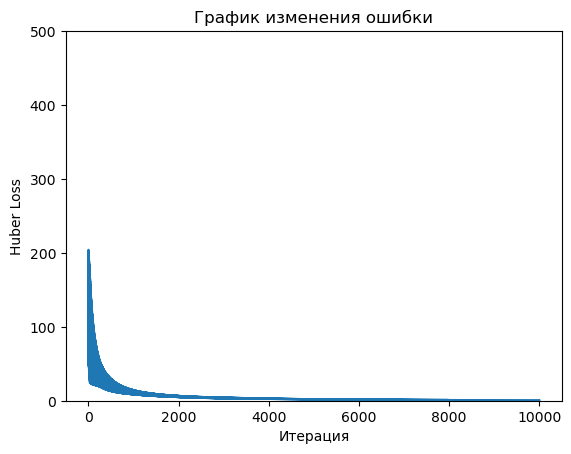

In [13]:
# Use Linear as a nucleus:
model_linear = SVRCustom(kernel='linear', C=1, eta0=0.1, max_iter=10000)
model_linear.fit(X_train, y_train)
model_linear.plot_loss(500)


In [14]:
y_pred = model_linear.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print(f"loss_history:{model_linear.loss_history[-1]}")

MAE: 1.1829476368640457
loss_history:0.7585238507380911


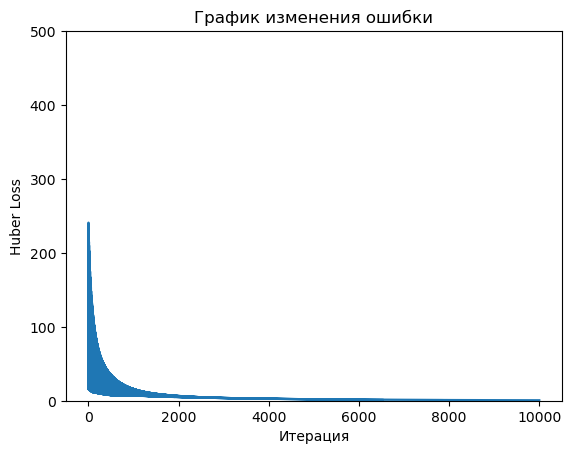

In [15]:
# Use RBF as a nucleus:
model_rbf = SVRCustom(kernel='rbf', C=100, max_iter=10000)
model_rbf.fit(X_train, y_train)
model_rbf.plot_loss(500)

In [16]:
y_pred_rbf = model_rbf.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred_rbf))
print(f"loss_history:{model_rbf.loss_history[-1]}")

MAE: 1.1635339208610538
loss_history:0.7361535906078129


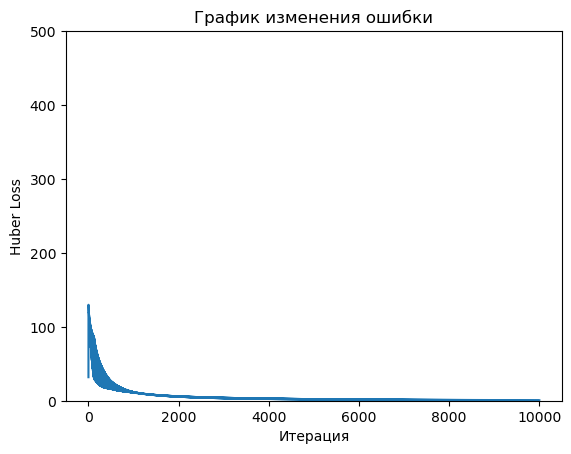

In [17]:
# Use Poly as a nucleus:
model_poly3 = SVRCustom(kernel='poly', degree=3, max_iter=10000)
model_poly3.fit(X_train, y_train)
model_poly3.plot_loss(500)

In [18]:
y_pred_poly3 = model_poly3.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred_poly3))
print(f"loss_history:{model_poly3.loss_history[-1]}")

MAE: 1.1610921741939493
loss_history:0.7004820395015872


# REMOVE OUR data and repeat our training

In [19]:
# Data normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

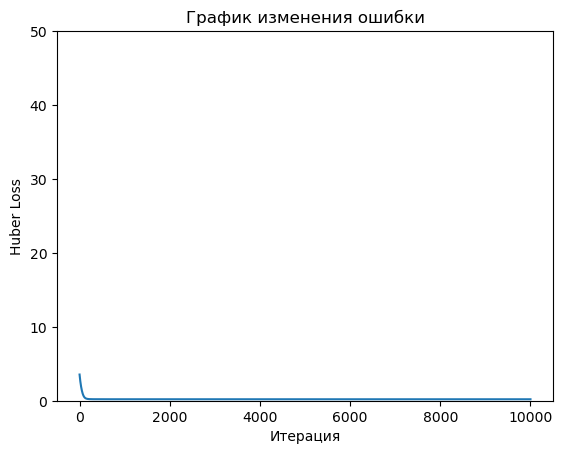

In [20]:
# Use Linear as a nucleus:
model_linear_norm = SVRCustom(kernel='linear', C=1, eta0=0.1, max_iter=10000)
model_linear_norm.fit(X_train_scaled, y_train)
model_linear_norm.plot_loss(50)


In [21]:
y_pred_norm = model_linear_norm.predict(X_test_scaled)
print("MAE:", mean_absolute_error(y_test, y_pred_norm))
print(f"loss_history:{model_linear_norm.loss_history[-1]}")

MAE: 0.5044677356449802
loss_history:0.19708677893950652


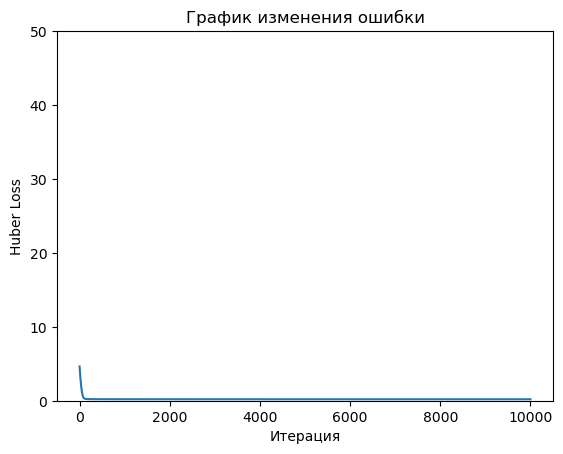

In [22]:
# Use RBF as a nucleus:
model_rbf_norm = SVRCustom(kernel='rbf', C=100, max_iter=10000)
model_rbf_norm.fit(X_train_scaled, y_train)
model_rbf_norm.plot_loss(50)

In [23]:
y_pred_rbf_norm = model_rbf_norm.predict(X_test_scaled)
print("MAE:", mean_absolute_error(y_test, y_pred_rbf_norm))
print(f"loss_history:{model_rbf_norm.loss_history[-1]}")

MAE: 0.504686483977524
loss_history:0.19740088085183993


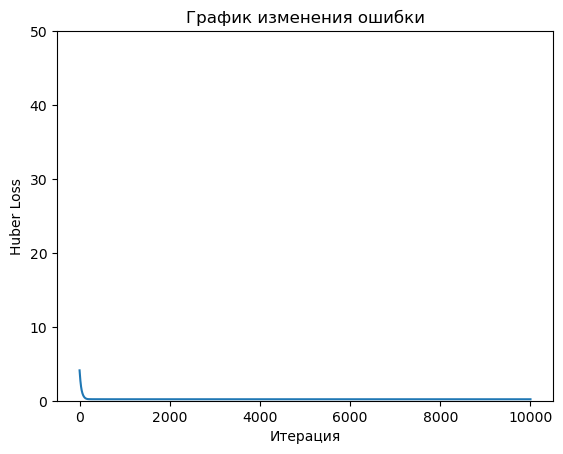

In [24]:
model_poly3_norm = SVRCustom(kernel='poly', degree=3, max_iter=10000)
model_poly3_norm.fit(X_train_scaled, y_train)
model_poly3_norm.plot_loss(50)

In [25]:
y_pred_poly3_norm = model_poly3_norm.predict(X_test_scaled)
print("MAE:", mean_absolute_error(y_test, y_pred_poly3_norm))
print(f"loss_history:{model_poly3_norm.loss_history[-1]}")

MAE: 0.5045114333502706
loss_history:0.1971279487159849


In [26]:
# Check for Degree = 5

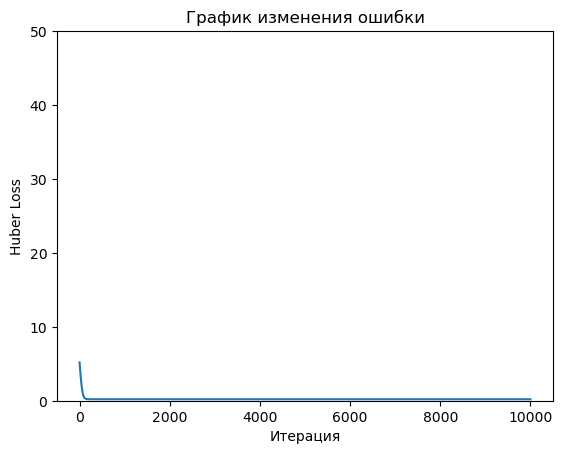

In [27]:
model_poly5_norm = SVRCustom(kernel='poly', degree=5, max_iter=10000)
model_poly5_norm.fit(X_train_scaled, y_train)
model_poly5_norm.plot_loss(50)

In [28]:
y_pred_poly5_norm = model_poly5_norm.predict(X_test_scaled)
print("MAE:", mean_absolute_error(y_test, y_pred_poly5_norm))
print(f"loss_history:{model_poly5_norm.loss_history[-1]}")

MAE: 0.5043474765748279
loss_history:0.1970228444991604


## Structure of the initial data and our models

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import math

def plot_comparison(X_train, X_train_scaled, model_linear, model_rbf, model_poly3, model_linear_norm, model_rbf_norm, model_poly3_norm, feature_names):
    """ 
    Builds graphs for each core with predictions before and after normalization.
    Parameters:
    X_train: original data for learning
    X_train_scaled: normalized data for learning
    Model_Linear: Model with a linear core before normalization
    model_rbf: model with RBF nucleus before normalization
    Model_Poly3: Model with a polynomial core before normalization
    model_linear_norm: a model with a line nucleus after normalization
    model_rbf_norm: model with rbf nucleus after normalization
    model_poly3_norm: model with a polynomial core after normalization
    feature_names: the names of the signs
    """
    
    kernels = ['linear', 'rbf', 'poly']
    models = [model_linear, model_rbf, model_poly3, model_linear_norm, model_rbf_norm, model_poly3_norm]
    model_labels = ['linear (до)', 'rbf (до)', 'poly (до)', 'linear (после)', 'rbf (после)', 'poly (после)']
    
    num_features = X_train.shape[1]
    num_columns = 3  # Number of columns per line
    num_rows = math.ceil(num_features / num_columns)  # Calculate the number of lines

    for kernel in kernels:
        plt.figure(figsize=(15, num_rows * 5))  # Increase the size of the graph
        
        # Break into several lines and columns
        for i in range(num_features):
            plt.subplot(num_rows, num_columns, i + 1)  # Distribute graphs to 3 columns
            
           # Cloud of points for each sign
            plt.scatter(X_train.iloc[:, i], y_train, color='black', alpha=0.7, label='Облако точек')

            # For each core
            if kernel == 'linear':
                y_pred_before = model_linear.predict(X_train)
                y_pred_after = model_linear_norm.predict(X_train_scaled)
            elif kernel == 'rbf':
                y_pred_before = model_rbf.predict(X_train)
                y_pred_after = model_rbf_norm.predict(X_train_scaled)
            elif kernel == 'poly':
                y_pred_before = model_poly3.predict(X_train)
                y_pred_after = model_poly3_norm.predict(X_train_scaled)
            
            # Line of model predictions to normalization
            plt.plot(X_train.iloc[:, i], y_pred_before, color='blue', label='Модель (до нормализации)')
            # Line of model predictions after normalization
            plt.plot(X_train.iloc[:, i], y_pred_after, color='red', label='Модель (после нормализации)')
            
            plt.xlabel(f"{feature_names[i]}")
            plt.ylabel("Предсказания модели")
            plt.title(f"{kernel} ядро: Признак {feature_names[i]}")
            plt.legend()

        plt.tight_layout(pad=2.0)  # Increase the indentation to prevent the application
        plt.show()

# We get the names of the signs
# feature_names = [f"Feature {i+1}" for i in range(X_train.shape[1])]  
feature_names = df.columns.tolist()


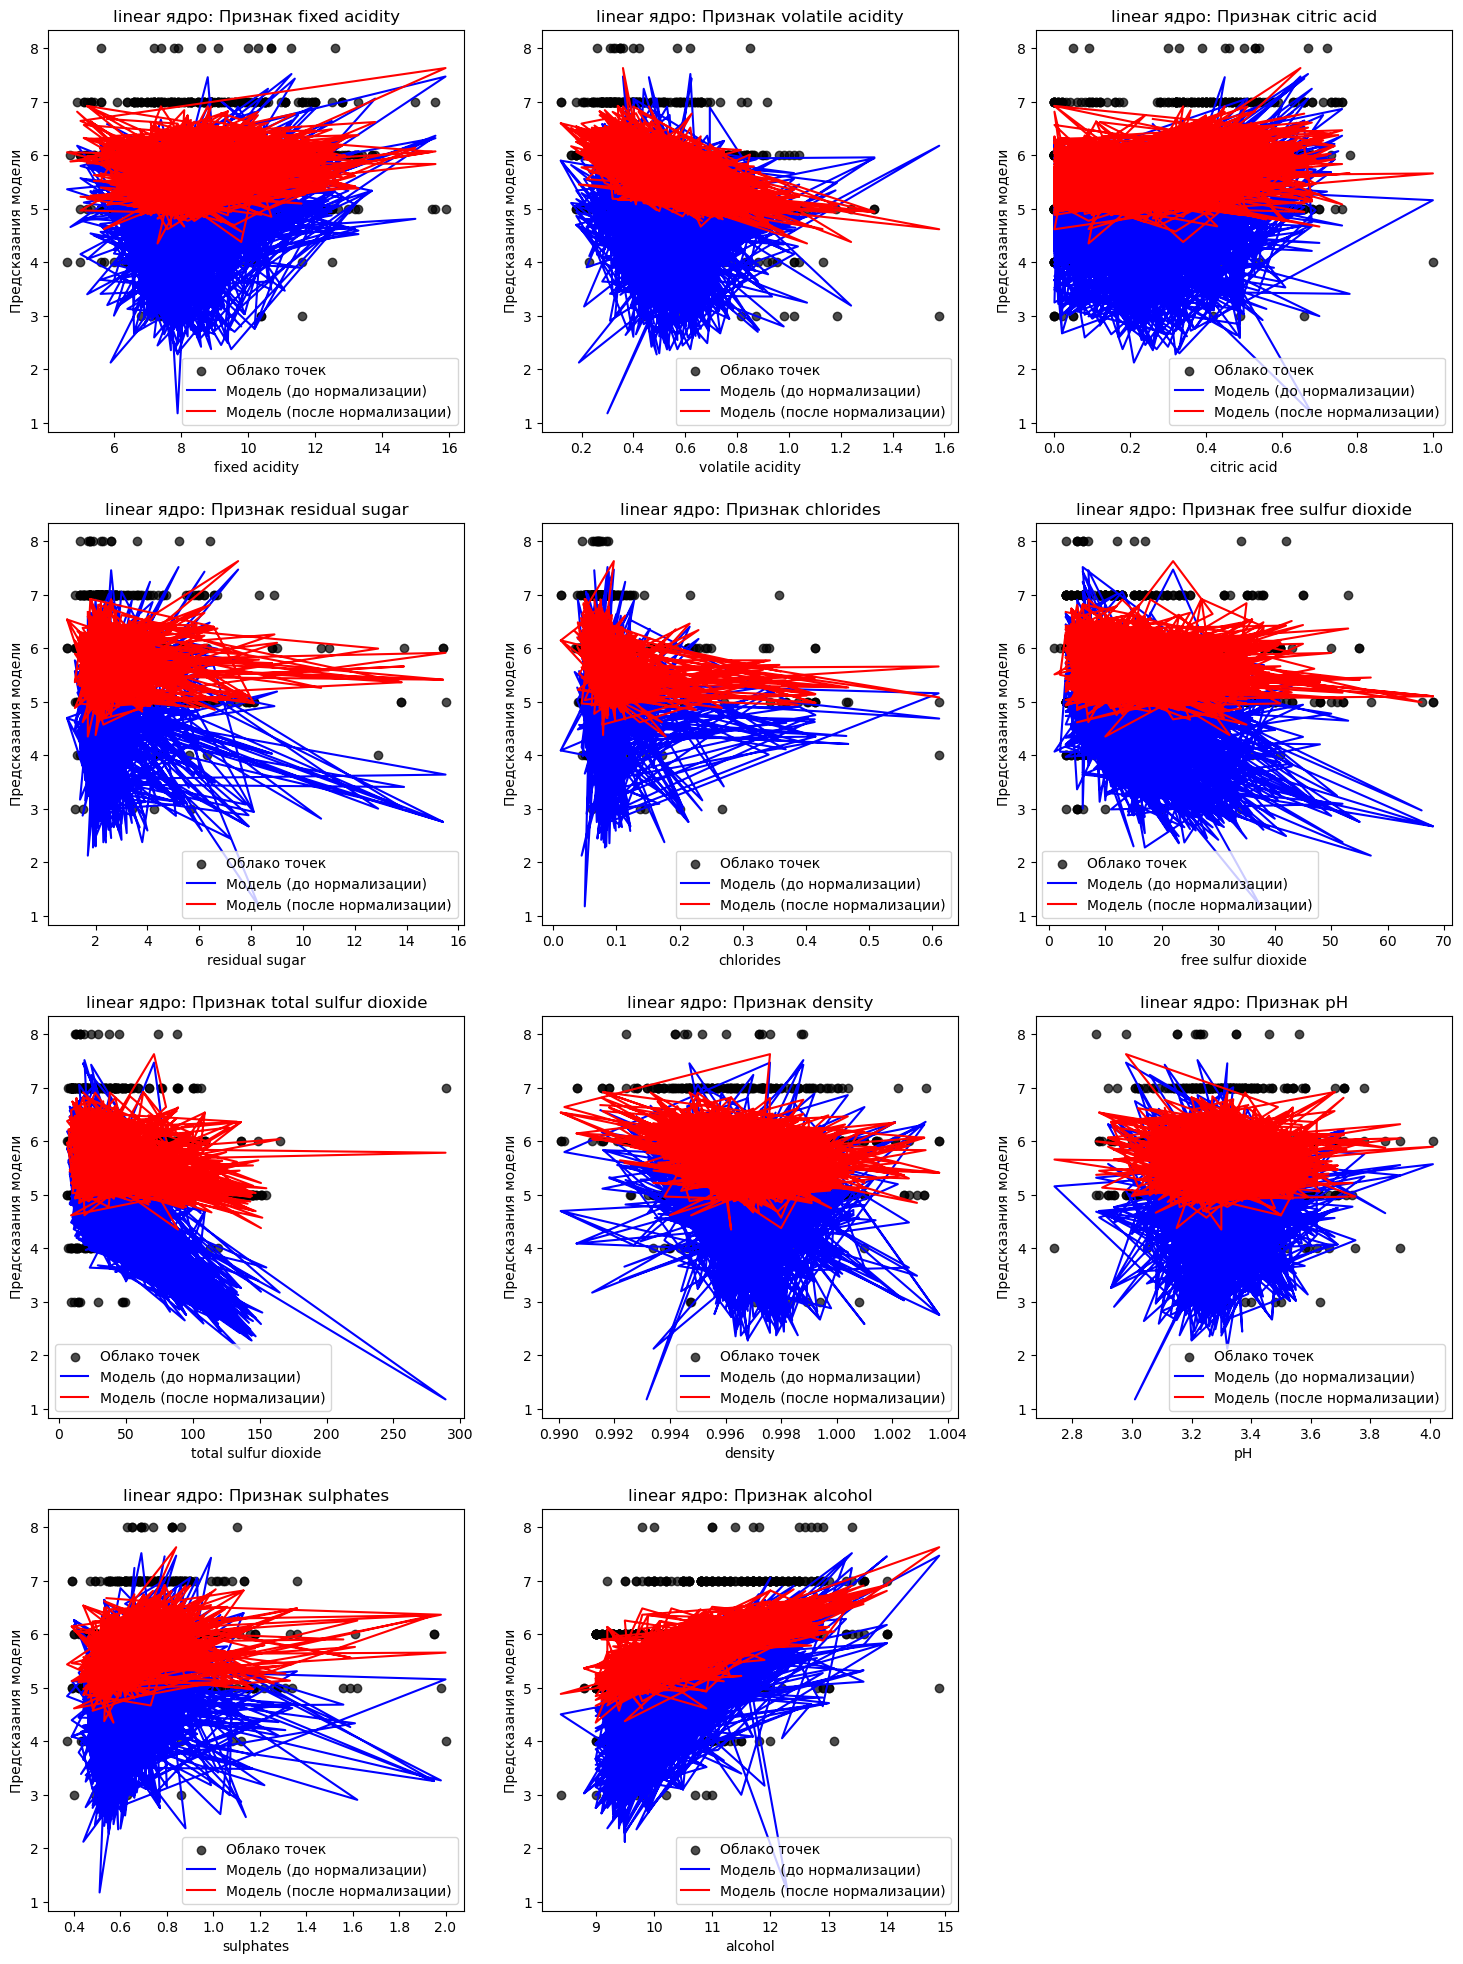

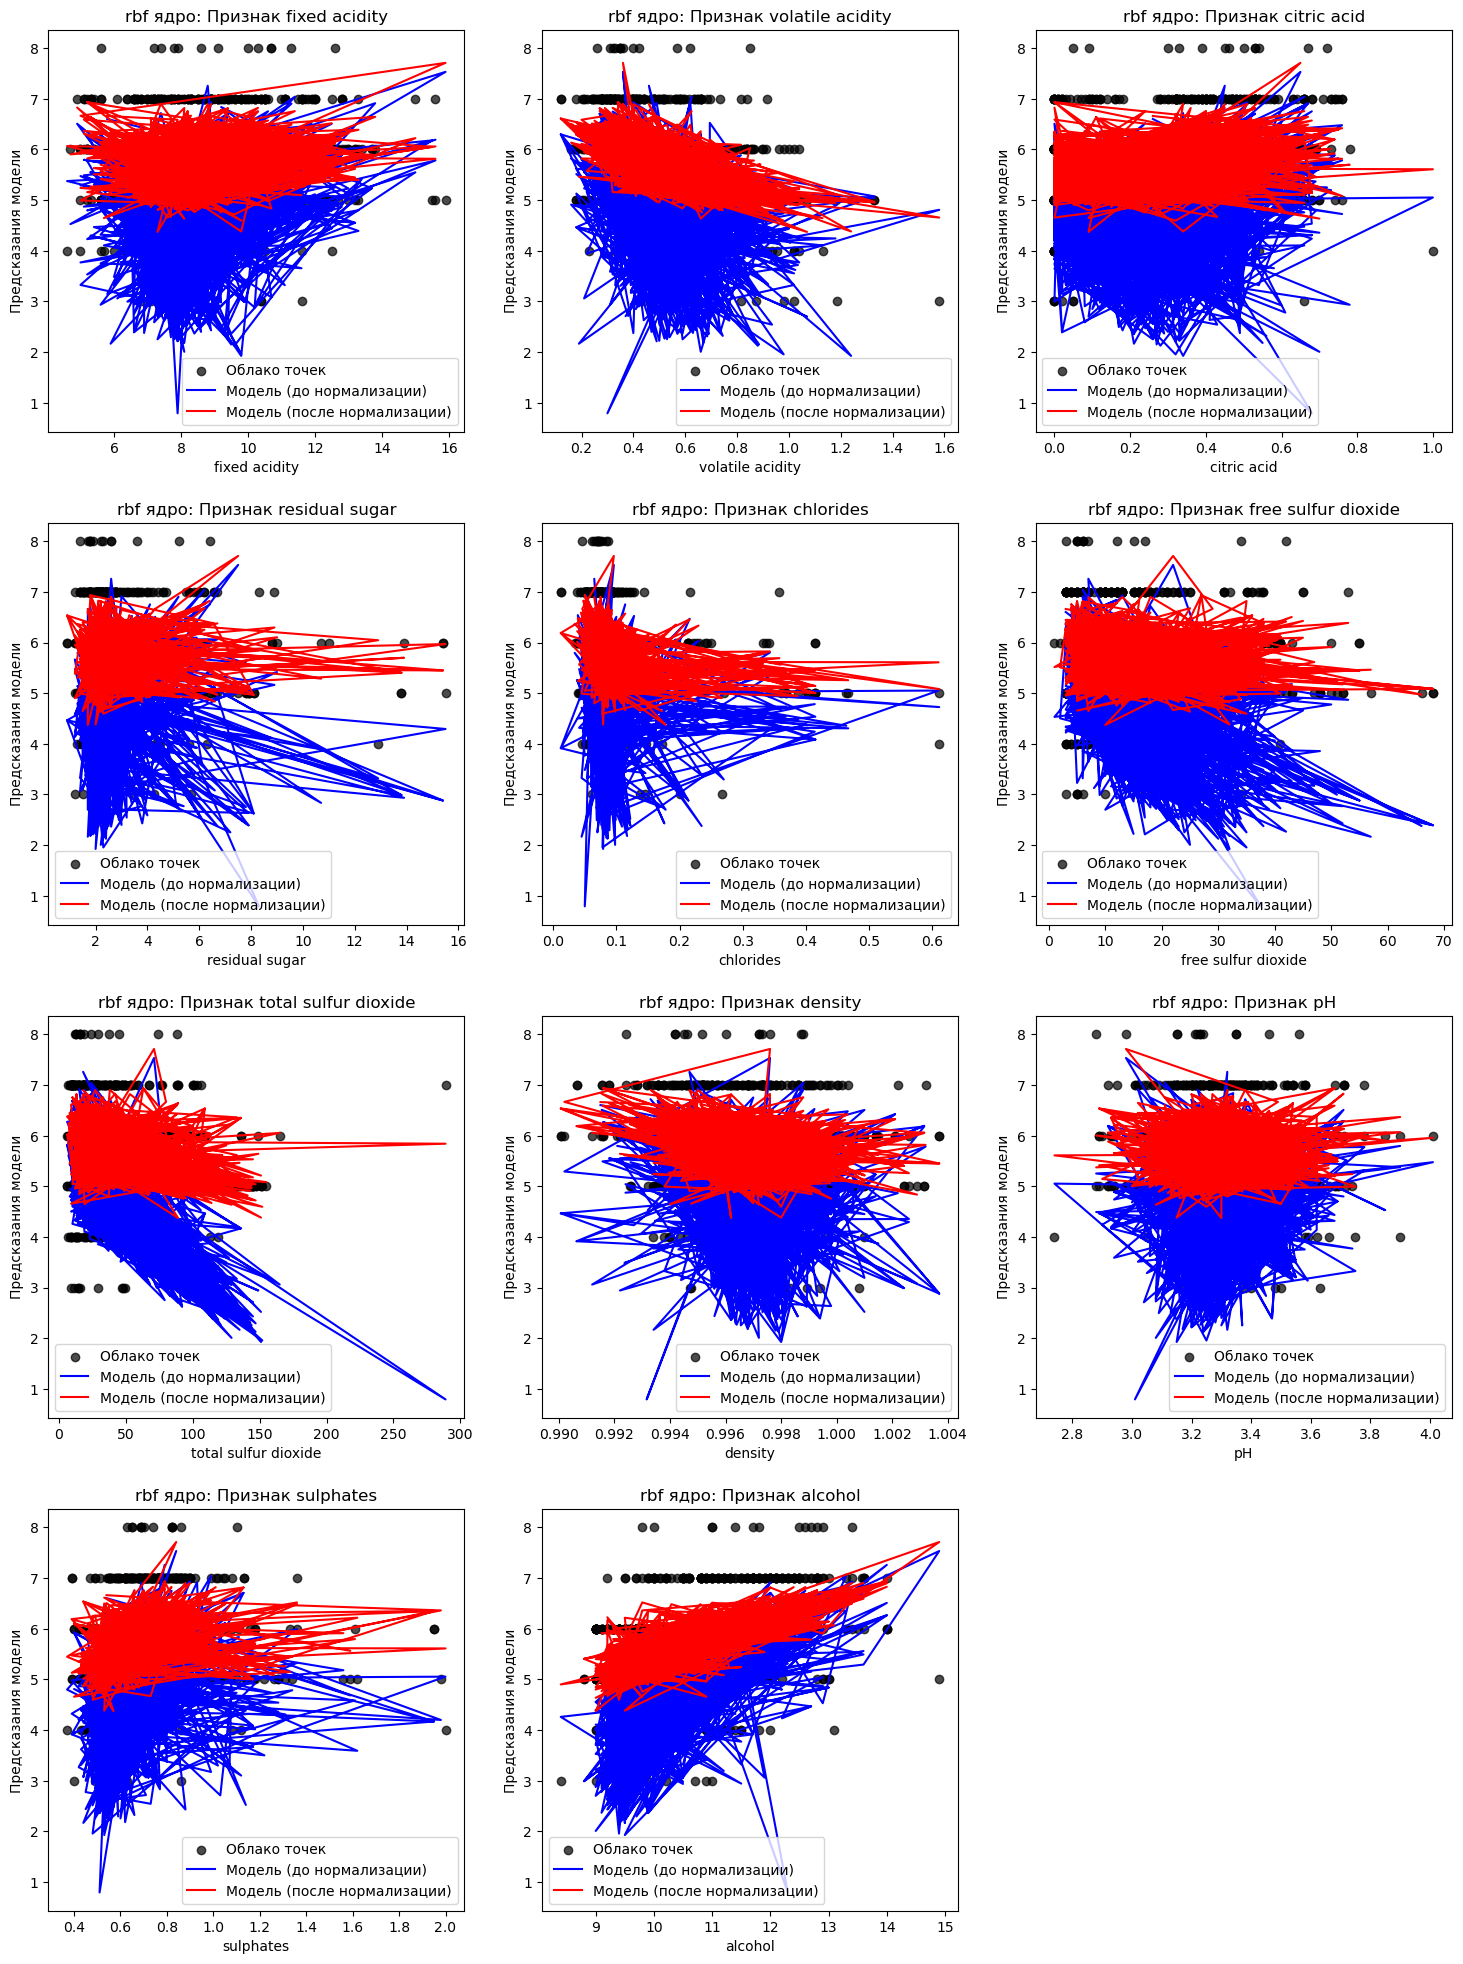

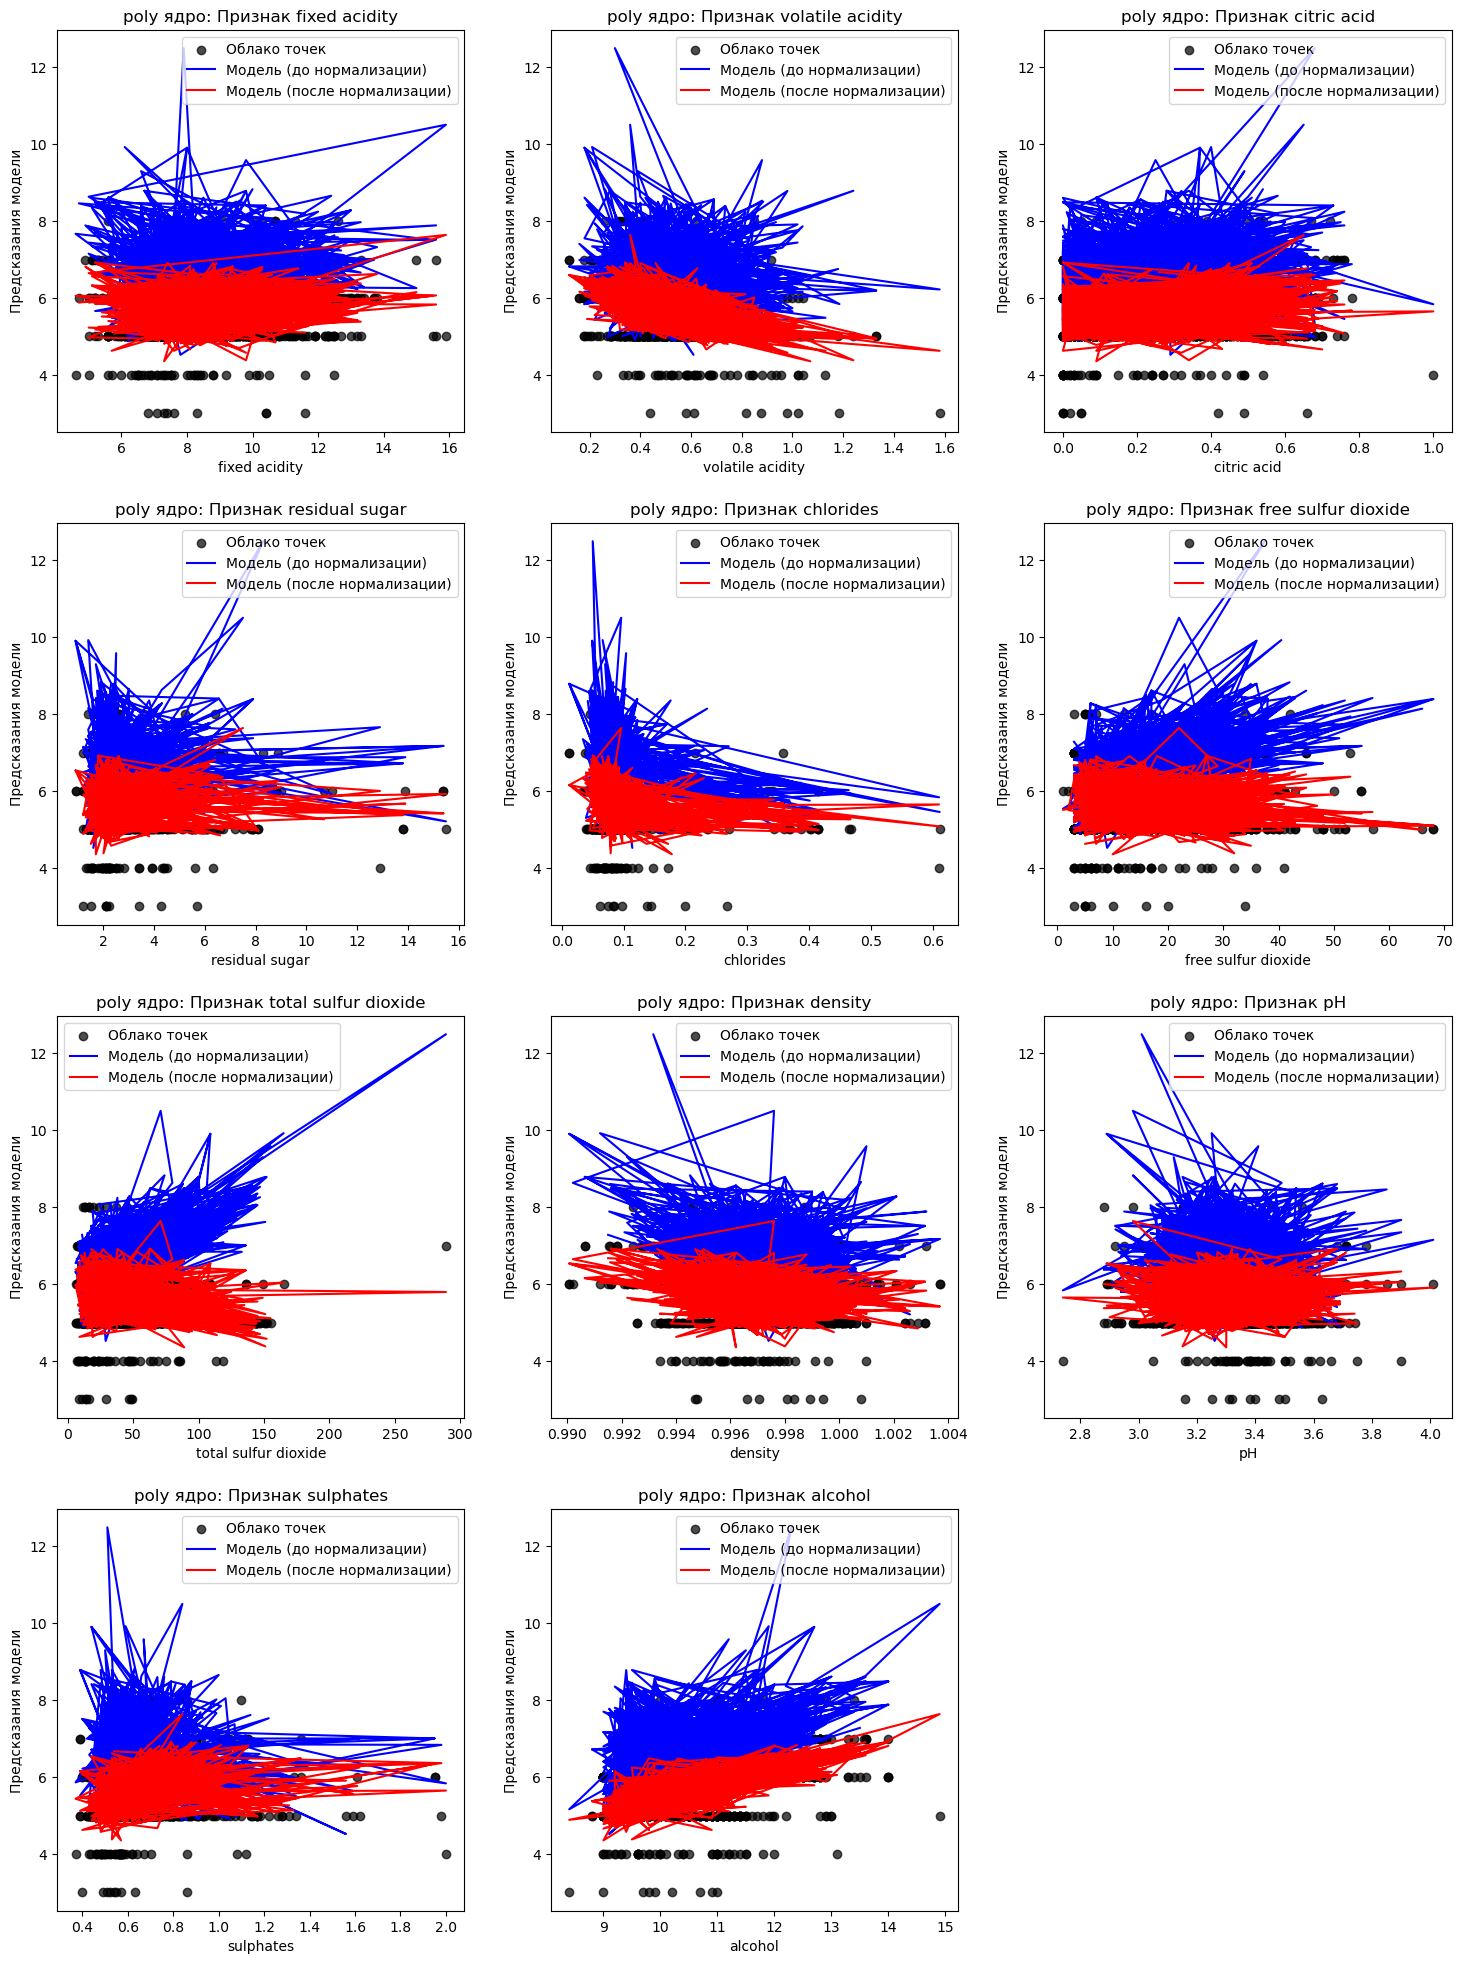

In [32]:
# We call the function to build graphs
plot_comparison(X_train, X_train_scaled, model_linear, model_rbf, model_poly3, model_linear_norm, model_rbf_norm, model_poly3_norm, feature_names)
